In [1]:
%matplotlib inline

from misc import *

from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from scipy.special import logit
from theano import shared
from itertools import product

import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
#Load the survey data

index1 = preprocess(pd.read_excel('data/RawData/IN10001.xls'))
index4 = preprocess(pd.read_excel('data/RawData/IN10004.xls'))
index5 = preprocess(pd.read_excel('data/RawData/IN10005.xls'))
index6 = preprocess(pd.read_excel('data/RawData/IN10006.xls'))
index7 = preprocess(pd.read_excel('data/RawData/IN10007.xls'))

#Create a new dataframe that only contains the demographic information that's included in each survey

common_columns = list(set(index1.columns).intersection(set(index7.columns)))

common_data = pd.concat([index1[common_columns],
                         index4[common_columns],
                         index5[common_columns],
                         index6[common_columns],
                         index7[common_columns]])

#Drop the columns that don't contain demographic information

common_data.drop(['ID', 'ADID IDFA', 'Time Started', 'Time Finished'], axis=1, inplace=True)

#Drop the columns where area is missing since the distributions for each demographic doesn't differ much

index1 = index1.loc[index1['Area'] != 'Unknown', :]
common_data = common_data.loc[common_data['Area'] != 'Unknown', :]

#Get count of respondents by state

common_data.groupby(['Area']).size().reset_index().values


array([['Alabama', 122],
       ['Alaska', 3],
       ['Arizona', 110],
       ['Arkansas', 37],
       ['California', 536],
       ['Colorado', 52],
       ['Connecticut', 44],
       ['Delaware', 9],
       ['District of Columbia', 33],
       ['Florida', 380],
       ['Georgia', 196],
       ['Hawaii', 10],
       ['Idaho', 22],
       ['Illinois', 286],
       ['Indiana', 105],
       ['Iowa', 59],
       ['Kansas', 36],
       ['Kentucky', 154],
       ['Louisiana', 72],
       ['Maine', 23],
       ['Maryland', 112],
       ['Massachusetts', 68],
       ['Michigan', 279],
       ['Minnesota', 70],
       ['Mississippi', 47],
       ['Missouri', 111],
       ['Montana', 9],
       ['Nebraska', 39],
       ['Nevada', 36],
       ['New Hampshire', 14],
       ['New Jersey', 96],
       ['New Mexico', 13],
       ['New York', 305],
       ['North Carolina', 220],
       ['North Dakota', 4],
       ['Ohio', 331],
       ['Oklahoma', 77],
       ['Oregon', 57],
       ['Pennsylvania', 

In [3]:
#Encode whether or not a respodent will vote in the 2018 House of Representatives election

def will_vote(answer):
    if answer == "Won't Vote":
        return 0
    else:
        return 1

#Encode whether or not a respondent will vote for a major party candidate given that he/she will be voting
    
def will_vote_major(answer):
    if answer == 'Will vote Republican' or answer == 'Will vote Democratic':
        return 1
    else:
        return 0

#Encode which major party candidate a respondent will vote for given that he/she will be voting for a major party candidate
    
def which_major(answer):
    if answer == 'Will vote Republican':
        return 0
    elif answer == 'Will vote Democratic':
        return 1
    
#Encode demographic columns and create marginal demographic columns using an overall dataset
    
def encode_demo(index, common):
    #Create separate LabelEncoder instances for each variable

    gender_enc = LabelEncoder()
    race_enc = LabelEncoder()
    age_enc = LabelEncoder()
    area_enc = LabelEncoder()
    edu_enc = LabelEncoder()
    div_enc = LabelEncoder()

    race_gender_enc = LabelEncoder()
    age_edu_enc = LabelEncoder()
    age_gender_enc = LabelEncoder()
    edu_gender_enc = LabelEncoder()
    
    area_gender_enc = LabelEncoder()
    area_race_enc = LabelEncoder()
    area_age_enc = LabelEncoder()
    
    #Enumerate the possible values for each variable using the overall dataset
    
    gender_list = common['Gender'].unique()
    age_list = common['Age'].unique()
    race_list = common['Race'].unique()
    edu_list = common['Education'].unique()
    area_list = common['Area'].unique()
    div_list = common['US Census Division'].unique()
    
    #Generate all possible combinations for each pair of variables using the overall dataset
    
    age_gender_list = [str(marginal) for marginal in product(common['Age'].unique(), common['Gender'].unique())]
    age_edu_list = [str(marginal) for marginal in product(common['Age'].unique(), common['Education'].unique())]
    race_gender_list = [str(marginal) for marginal in product(common['Race'].unique(), common['Gender'].unique())]
    edu_gender_list = [str(marginal) for marginal in product(common['Education'].unique(), common['Gender'].unique())]
    
    area_gender_list = [str(marginal) for marginal in product(common['Area'].unique(), common['Gender'].unique())]
    area_race_list = [str(marginal) for marginal in product(common['Area'].unique(), common['Race'].unique())]
    area_age_list = [str(marginal) for marginal in product(common['Area'].unique(), common['Age'].unique())]
    
    #Fit each LabelEncoder instance to its respective list of values
    
    gender_enc.fit(gender_list)
    race_enc.fit(race_list)
    age_enc.fit(age_list)
    area_enc.fit(area_list)
    edu_enc.fit(edu_list)
    div_enc.fit(div_list)
    
    race_gender_enc.fit(race_gender_list)
    age_edu_enc.fit(age_edu_list)
    age_gender_enc.fit(age_gender_list)
    edu_gender_enc.fit(edu_gender_list)
    
    area_gender_enc.fit(area_gender_list)
    area_race_enc.fit(area_race_list)
    area_age_enc.fit(area_age_list)
    
    #Encode the individual categories as integers

    index['Gender Encoded'] = gender_enc.transform(index['Gender'])
    index['Race Encoded'] = race_enc.transform(index['Race'])
    index['Age Encoded'] = age_enc.transform(index['Age'])
    index['Area Encoded'] = area_enc.transform(index['Area'])
    index['Education Encoded'] = edu_enc.transform(index['Education'])
    index['Division Encoded'] = div_enc.transform(index['US Census Division'])
    
    #Create new columns for the marginal categories
    
    def concat(col1, col2):
        pair = (col1, col2)
        
        return str(pair)

    index['Race_Gender'] = index[['Race', 'Gender']].apply(lambda row: concat(row[0], row[1]), axis=1)
    index['Age_Education'] = index[['Age', 'Education']].apply(lambda row: concat(row[0], row[1]), axis=1)
    index['Age_Gender'] = index[['Age', 'Gender']].apply(lambda row: concat(row[0], row[1]), axis=1)
    index['Education_Gender'] = index[['Education', 'Gender']].apply(lambda row: concat(row[0], row[1]), axis=1)
    
    index['Area_Gender'] = index[['Area', 'Gender']].apply(lambda row: concat(row[0], row[1]), axis=1)
    index['Area_Race'] = index[['Area', 'Race']].apply(lambda row: concat(row[0], row[1]), axis=1)
    index['Area_Age'] = index[['Area', 'Age']].apply(lambda row: concat(row[0], row[1]), axis=1)

    #Encode the marginal categories as integers

    index['Race_Gender'] = race_gender_enc.transform(index['Race_Gender'])
    index['Age_Education'] = age_edu_enc.transform(index['Age_Education'])
    index['Age_Gender'] = age_gender_enc.transform(index['Age_Gender'])
    index['Education_Gender'] = edu_gender_enc.transform(index['Education_Gender'])
    
    index['Area_Gender'] = area_gender_enc.transform(index['Area_Gender'])
    index['Area_Race'] = area_race_enc.transform(index['Area_Race'])
    index['Area_Age'] = area_age_enc.transform(index['Area_Age'])

    return index

#Perform one hot encoding on the possible answers for any given question

def ohe_question(index, question):
    col_name = ' '.join(question.split(' ')[:4])
    index = pd.concat([index1,
                       pd.get_dummies(index1[question],
                                      prefix=col_name,
                                      prefix_sep='|')],
                      axis=1)
    
    return index


In [4]:
index1['Will Vote'] = index1['Who will you vote for in the House of Representatives in 2018?'].apply(lambda row: will_vote(row))
index1['Will Vote Major'] = index1['Who will you vote for in the House of Representatives in 2018?'].apply(lambda row: will_vote_major(row))
index1['Which Major'] = index1['Who will you vote for in the House of Representatives in 2018?'].apply(lambda row: which_major(row))

index1 = encode_demo(index1, common_data)
common_data = encode_demo(common_data, common_data)

question = 'How many of your close friends and family are studying at, or have graduated from, a four year college?'
index1 = ohe_question(index1, question)

In [5]:
#Group by race, gender, education, and age to see how many are in each cell and how many in each cell will vote

index1_unique = index1.groupby(['Gender Encoded',
                                'Age Encoded',
                                'Age_Gender',
                                'Area Encoded',
                                'Division Encoded'])["How many of your|Don't know"]
index1_unique = index1_unique.agg([("How many of your|Don't know", 'sum'), ('n', 'size')]).reset_index()


In [6]:
#Obtain a mapping from each state to its census division

division_map = common_data.groupby(['Area', 'US Census Division', 'Area Encoded', 'Division Encoded']).size().reset_index()[['Area', 'US Census Division', 'Area Encoded', 'Division Encoded']]

#Remove duplicate state rows where the census division is missing

division_map = division_map.loc[division_map['US Census Division'] != 'Unknown'].reset_index(drop=True)


In [7]:
#Load the 2016 Presidential Election results by state, taken from:
#https://www.dailykos.com/stories/2016/11/25/1601042/-Nerd-Alert-This-spreadsheet-contains-every-presidential-election-by-state-from-1828-to-2016


state_df = pd.read_csv('demographics/US Presidential Results & PVIs by State 1828-2016 - 2-Party US Pres Results & PVIs.csv',
                       header=1, usecols=[0, 2])
state_df.columns = ['Area', 'Trump Vote']

#Use the same name for District of Columbia in both dataframes

state_df.loc[state_df['Area'] == 'Washington DC', 'Area'] = 'District of Columbia'


#Join the 2016 Election results with the census divisions

state_df = state_df.merge(division_map)

#Calculate the log odds of the proportion of each state's voters that voted for Donald Trump in 2016

state_trump = logit(state_df['Trump Vote'].values/100)


In [8]:
#Create Theano constant variables for the demographic and marginal demographic variables

age = shared(index1_unique['Age Encoded'].values)
gender = shared(index1_unique['Gender Encoded'].values)
area = shared(index1_unique['Area Encoded'].values)

age_gender = shared(index1_unique['Age_Gender'].values)

#Create a Theano constant variable for the number of observations in each population cell

n = shared(index1_unique['n'].values)


In [9]:
index1_unique

,Gender Encoded,Age Encoded,Age_Gender,Area Encoded,Division Encoded,How many of your|Don't know,n
0,0,0,0,0,1,0,1
1,0,0,0,2,3,0,2
2,0,0,0,4,5,0,3
3,0,0,0,4,7,0,1
4,0,0,0,5,3,0,1
5,0,0,0,9,6,2,2
6,0,0,0,22,0,1,3
7,0,0,0,25,8,0,4
8,0,0,0,32,2,0,3
9,0,0,0,33,6,0,3


In [10]:
#Define the model for the state-level effects coefficient

def hierarchical_normal(name, shape, mu=0.0):
    delta = pm.Normal('delta_{}'.format(name), 0.0, 1.0, shape=shape)
    sigma = pm.HalfCauchy('sigma_{}'.format(name), 5.0)
    
    return pm. Deterministic(name, mu + delta*sigma)


In [11]:
"""
This section creates the state-level variables.
===============================================

The length of the alpha_division coefficient vector is
the number of unique census divisions.
The length of the alpha_state coefficient vector is the
number of unique state values, excluding "Unknown".

The alpha_division and alpha_state variables have a mean of 0 and
a standard deviation of delta*sigma, where delta is sampled from a
normal distribution with a mean of 0 and standard deviation of 1, and
sigma is sampled from a half Cauchy distribution with beta = 5.

The beta_trump variable is the intercept for the support for Trump in
each state in the 2016 election. This variable is normally distributed
with a mean of 0 and a standard deviation of 5.

The mu_area vector represents the mean for each of the 50 states
and Washington DC.
The state_trump vector is the log odds of support for Trump in each state
in the 2016 election.
"""

with pm.Model() as model:
    alpha_division = hierarchical_normal(name='region',
                                         shape=common_data['Division Encoded'].unique().size)
    beta_trump = pm.Normal('trump', 0.0 , 5.0)
    mu_area = alpha_division[division_map['Division Encoded'].values] + beta_trump*state_trump
    alpha_area = hierarchical_normal(name='area',
                                     shape=common_data['Area Encoded'].unique().size,
                                     mu=mu_area)


In [11]:
"""
This section creates the general population variables.
======================================================

The intercept beta_0 uses an initial value for sampling that's equal to
the log odds of a respondent voting based on the survey responses.

Each of the general population demographic and marginal demographic
variables have a mean of 0 and a standard deviation of delta*sigma,
where delta is sampled from a normal distribution with a mean of 0
and standard deviation of 1, and sigma is sampled from a
half Cauchy distribution with beta = 5.

The variable eta is the multilevel logistic regression model that models
the log odds of the voter turnout rate.

"""
with pm.Model() as model:
#with model:
    beta_0 = pm.Normal('beta_0', 0.0, 5.0,
                       testval=logit(index1["How many of your|Don't know"].values.mean()))
     
    alpha_age_gender = hierarchical_normal(name='age_gender',
                                           shape=common_data['Age_Gender'].unique().size)

    alpha_age = hierarchical_normal(name='age',
                                    shape=common_data['Age'].unique().size)
    alpha_gender = hierarchical_normal(name='gender',
                                       shape=common_data['Gender'].unique().size)
    
    eta = (beta_0 +
           alpha_age_gender[age_gender] +
           alpha_age[age] +
           alpha_gender[gender] )
#           + alpha_area[area])


In [12]:
#Define the observed random variables using a binomial distribution with a probability equal to eta

with model:
    p = pm.math.sigmoid(eta)
    obs = pm.Binomial('obs', n, p,
                      observed=index1_unique["How many of your|Don't know"].values)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 139.68:   9%|▊         | 17383/200000 [00:03<00:36, 4963.82it/s]
Convergence archived at 17600
Interrupted at 17,599 [8%]: Average Loss = 296.53
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_gender_log__, delta_gender, sigma_age_log__, delta_age, sigma_age_gender_log__, delta_age_gender, beta_0]
100%|██████████| 5000/5000 [07:37<00:00, 12.69it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `ta

1.00061376858


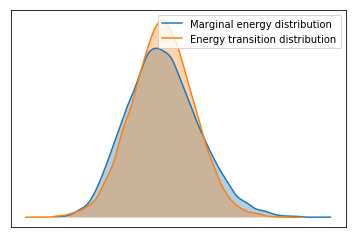

In [16]:
#Sample the model using ADVI as the initialization method for the NUTS sampler
#(the default setting will cause an error)


with model:
    trace = pm.sample(draws=2000,
                      tune=4000,
                      nuts_kwargs={'target_accept': 0.99},
                      init='advi+adapt_diag',
                      njobs=10)

joblib.dump(trace, 'trace_age_gender.pkl')
print(max(np.max(score) for score in pm.gelman_rubin(trace).values()))
pm.energyplot(trace)


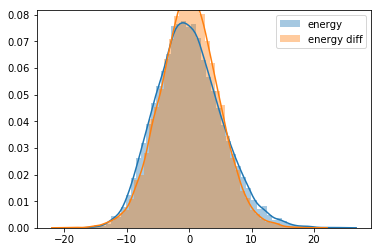

In [17]:
#Compare the distribution of energy levels to the distribution of changes in energy levels between samples

energy = trace['energy']
energy_diff = np.diff(energy)
sb.distplot(energy - energy.mean(), label='energy')
sb.distplot(energy_diff, label='energy diff')
plt.legend()


Number of Divergent 82
Percentage of Divergent 0.04100


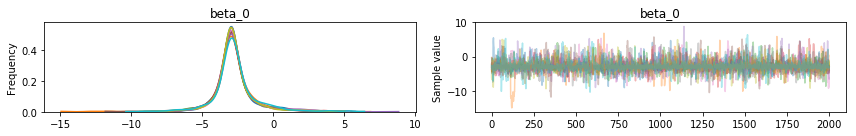

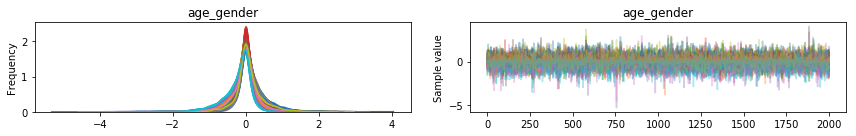

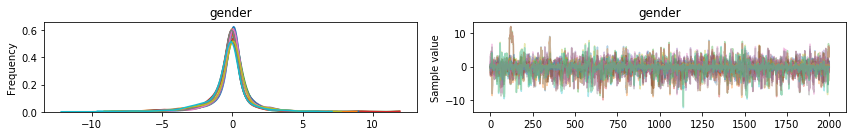

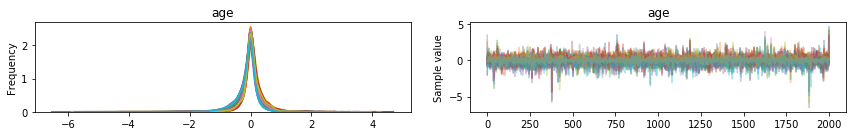

In [18]:
# Display the trace plot and density plot for each variable

model_vars = [beta_0,
              alpha_age_gender,
              alpha_gender,
              alpha_age]

for var in model_vars:
    pm.traceplot(trace, varnames=[var])
    
# Display the total number and percentage of divergent transitions

divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace)
print('Percentage of Divergent %.5f' % divperc)
    

In [ ]:
#Perform a posterior predictive check to ensure that the sample distribution overlaps with the dataset mean

ppc = pm.sample_ppc(trace, samples=1000, model=model)

_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['obs']], bins=19, alpha=0.5)
ax.axvline(index1_unique["How many of your|Don't know"].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
